## Setup and Data Loading

In [107]:
import os
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm 
import pandas as pd
from sklearn.model_selection import KFold
from collections import Counter

In [108]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


In [109]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)

torch version :  2.5.1+cu124
torchvision version :  0.20.1+cu124
numpy version :  1.26.4
matplotlib version :  3.9.2


## Exploring the dataset

In [110]:
! ls -l ../data

total 16
-rw-r--r-- 1 root root 1436 Jan 24 18:32 README.md
drwxr-xr-x 6 root root 4096 Jan 24 17:58 Testing
drwxr-xr-x 6 root root 4096 Jan 24 17:54 Training
-rw-r--r-- 1 root root 2090 Jan 24 18:20 data.ipynb


In [111]:
train_dir = os.path.join("..","data", "Training")

In [112]:
# check the diffenent classes of the dataset
classes = os.listdir(train_dir)
classes

['pituitary', 'meningioma', 'notumor', 'glioma']

In [113]:
def sample_images(data_path, classname):
    class_dir = os.path.join(data_path, classname)
    if not os.path.exists(class_dir):
        return "Invalid directory"
    image_list = os.listdir(class_dir)
    if len(image_list) < 4:
        return "Not enough images in folder"

    # Pick four random images
    images_sample = random.sample(image_list, 4)

    # Plot them
    plt.figure(figsize=(20, 20))
    for i in range(4):
        img_loc = os.path.join(class_dir, images_sample[i])
        img = PIL.Image.open(img_loc)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")

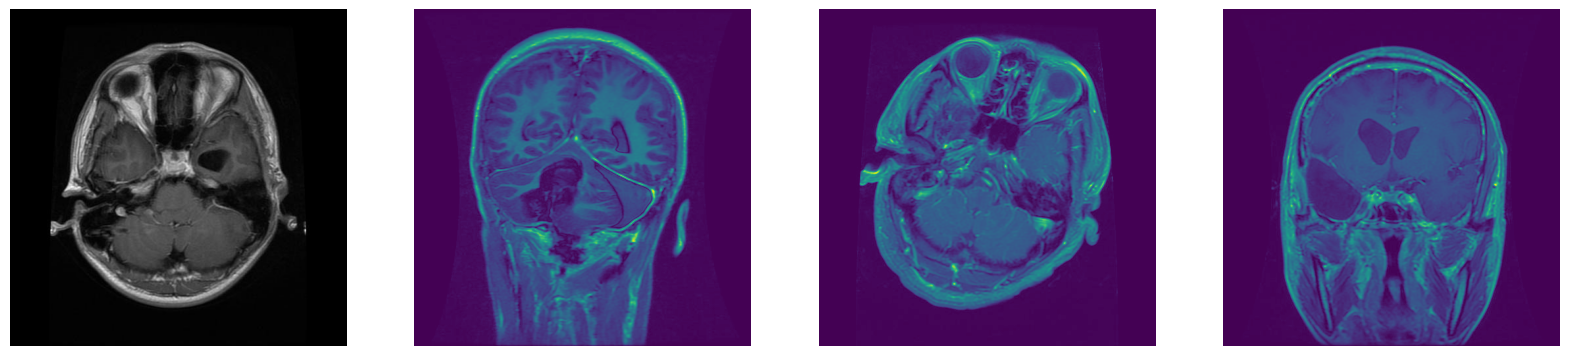

In [114]:
sample_images(train_dir, "glioma")

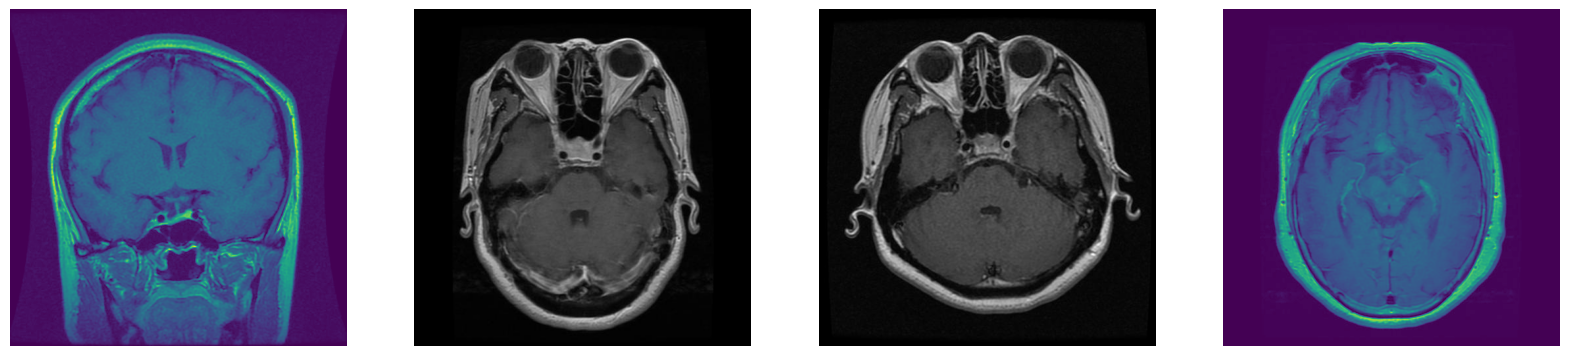

In [115]:
sample_images(train_dir, "pituitary")

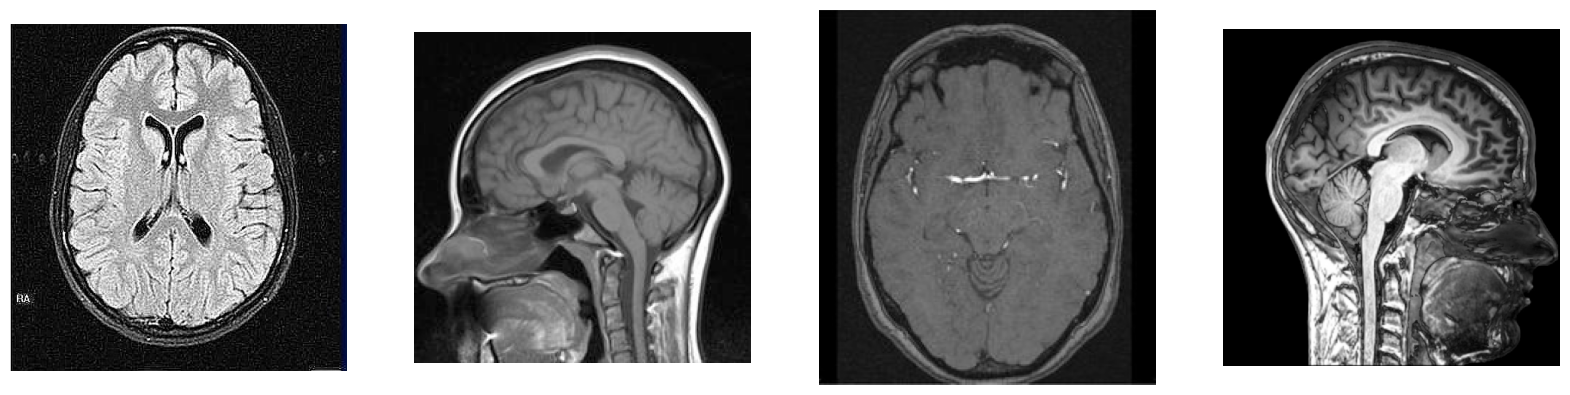

In [116]:
sample_images(train_dir, "notumor")

#### View the the number of image in each directory 

In [117]:
glioma_dir = os.path.join(train_dir,"glioma")
print(f"Number of glioma image: {len(os.listdir(glioma_dir))}")

Number of glioma image: 1321


In [118]:
meningioma_dir = os.path.join(train_dir,"meningioma")
print(f"Number of glioma image: {len(os.listdir(meningioma_dir))}")

Number of glioma image: 1339


In [119]:
notumor_dir = os.path.join(train_dir,"notumor")
print(f"Number of glioma image: {len(os.listdir(notumor_dir))}")

Number of glioma image: 1595


In [120]:
pituitary_dir = os.path.join(train_dir,"notumor")
print(f"Number of glioma image: {len(os.listdir(pituitary_dir))}")

Number of glioma image: 1595


#### Check the shape and number of channel in the image dataset

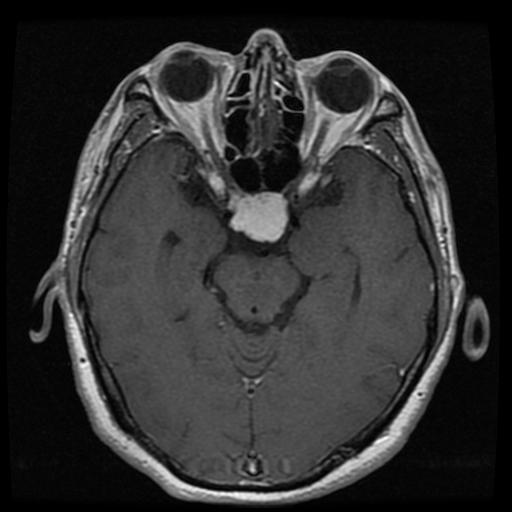

In [121]:
meningioma_sample = os.listdir(meningioma_dir)[0]
meningioma_sample_img = PIL.Image.open(os.path.join(meningioma_dir, meningioma_sample))
meningioma_sample_img

In [122]:
meningioma_sample_img.mode, meningioma_sample_img.size

('L', (512, 512))

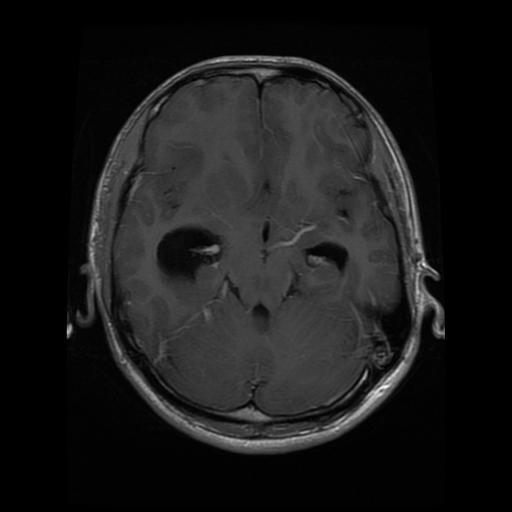

In [123]:
glioma_sample = os.listdir(glioma_dir)[1050]
glioma_sample_img = PIL.Image.open(os.path.join(glioma_dir, glioma_sample))
glioma_sample_img

In [124]:
glioma_sample_img.mode, glioma_sample_img.size

('L', (512, 512))

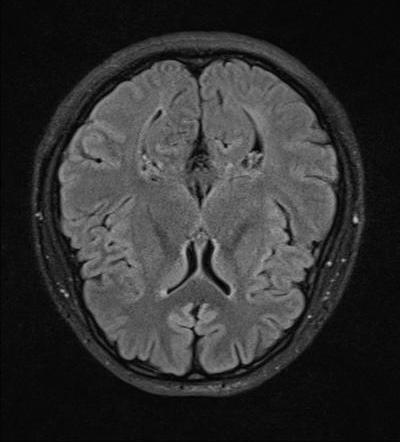

In [125]:
notumor_sample = os.listdir(notumor_dir)[1050]
notumor_sample_img = PIL.Image.open(os.path.join(notumor_dir, notumor_sample))
notumor_sample_img

In [126]:
notumor_sample_img.mode, notumor_sample_img.size

('RGB', (400, 442))

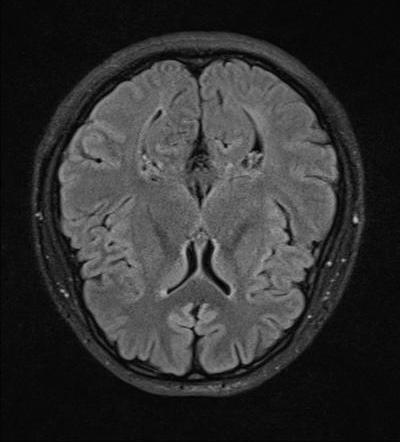

In [127]:
pituitary_sample = os.listdir(pituitary_dir)[1050]
pituitary_sample_img = PIL.Image.open(os.path.join(pituitary_dir, pituitary_sample))
pituitary_sample_img

In [128]:
pituitary_sample_img.mode, pituitary_sample_img.size

('RGB', (400, 442))

_The dataset does not have the same size and mode we have to convert them to the same channel and also to the same size_

In [129]:
class ConvertImage:
    def __call__(self, img):
        if img.mode != 'RGB':
            img = img.convert("RGB")
        return img    

### Normalize the dataset

In [130]:
transform_nonorm = transforms.Compose(
    [
        ConvertImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)

batch_size=32

In [134]:
# load the dataset to get the mean and std  to use for normalization
dataset = datasets.ImageFolder(train_dir, transform=transform_nonorm)
loader = DataLoader(dataset, batch_size=batch_size)

In [132]:
def mean_std(loader):
    count, count_square, num_batches = 0,0, 0
    for data, _ in tqdm(loader):
        count += torch.mean(data, dim=[0, 2, 3])
        count_square += torch.mean(data ** 2, dim=[0,2,3])
        num_batches += 1
        
    mean = count / num_batches
    std = (count_square / num_batches - mean**2) ** 0.5
    
    return mean, std

In [133]:
mean, std = mean_std(loader)

100%|██████████| 179/179 [00:43<00:00,  4.09it/s]


In [135]:
mean, std

(tensor([0.1855, 0.1856, 0.1856]), tensor([0.2003, 0.2003, 0.2003]))

_We have not normalized the data so the mean is not 0 and std is not one_

In [136]:
transform = transforms.Compose(
    [
        ConvertImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

In [137]:
batch_size = 32
dataset = datasets.ImageFolder(train_dir, transform=transform)

we now have the normalized mean and std

In [138]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    try:
        class_to_index = dataset.class_to_idx
    except AttributeError:
        class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [139]:
class_counts(dataset)

100%|██████████| 5712/5712 [00:34<00:00, 166.62it/s]


glioma        1321
meningioma    1339
notumor       1595
pituitary     1457
dtype: int64

### Building a CNN Network for the classification using pretrained Resnet model
_I would try out 2 different pretrained model, Densenet and Resnet the choose to tune the one which give the best basic performance for parameter tuning_

In [143]:
desnet = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)

In [144]:
resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

In [145]:
for params in resnet.parameters():
    params.requires_grad = False
    
for params in desnet.parameters():
    params.requires_grad = False

In [147]:
#  move the models to device
resnet.to(device)
desnet.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [149]:
# get the name of the last layer of the pretrained network
print(list(resnet.named_modules())[-1])
print(list(desnet.named_modules())[-1])

('fc', Linear(in_features=2048, out_features=1000, bias=True))
('classifier', Linear(in_features=1024, out_features=1000, bias=True))


In [150]:
# get the number of input feature of the last layer
print(resnet.fc.in_features)
print(desnet.classifier.in_features)

2048
1024


In [154]:
classifier_resnet = torch.nn.Sequential(
    torch.nn.Linear(in_features=2048, out_features=1024),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=1024, out_features=512),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=512, out_features=4),
)

classifier_desnet = torch.nn.Sequential(
    torch.nn.Linear(in_features=1024, out_features=512),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=512, out_features=256),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=256, out_features=4)
)

In [155]:
resnet.fc = classifier_resnet
desnet.classifier = classifier_desnet

In [169]:
# define optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
optimizer_res = optim.Adam(resnet.parameters())
optimizer_des = optim.Adam(desnet.parameters())

In [157]:
# get the name given to each submodule
resnet.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=512, out_features=4, bias=True)
)

In [160]:
# get the names of the submodule
desnet.classifier

Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=256, out_features=4, bias=True)
)

_I am going to be using cross-validation to train the model, to get an accurate values, I need to reset the model for each folds_

In [162]:
def reset_classifier(model):
    """
    Resets the parameters of the classifier layer for both ResNet and DenseNet models.
    
    Args:
        model: The model whose classifier parameters are to be reset. 
               Supports torchvision's ResNet and DenseNet architectures.
    """
    if hasattr(model, "fc"):  # For ResNet
        classifier = model.fc
    elif hasattr(model, "classifier"):  # For DenseNet
        classifier = model.classifier
    else:
        raise ValueError("The provided model does not have a recognizable classifier attribute.")
    
    # Reset the parameters of the classifier submodules
    for submodule in ["0", "3", "6"]:
        if submodule in classifier._modules:  
            classifier.get_submodule(submodule).reset_parameters()


### Define the functions for training and evaluating the models

In [176]:
def train_model(dataloader, device, optimizer, loss_fn, model):
    
    model.train()
    training_loss = 0.0
    for data, label in tqdm(dataloader):
        optimizer.zero_grad()
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = loss_fn(output, label)
        
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item() * data.size(0)
        
    return training_loss / len(dataloader.dataset)
        

In [166]:
def predict(model, dataloader, device):
    model.eval()
    prob = torch.tensor([]).to(device)
    
    with torch.no_grad():
        for data, label in tqdm(dataloader):
            data = data.to(device)
            output = model(data)
            out_prob = nn.functional.softmax(output, dim=1)
            
            prob = torch.cat((prob, out_prob), dim=0)
    return prob

In [171]:
def loss_accuracy(dataloader, loss_fn, model, device):
    total_loss = 0
    total_correct = 0
    
    model.eval()
    
    with torch.no_grad():
        for data, label in tqdm(dataloader):
            data = data.to(device)
            output = model(data)
            
            label = label.to(device)
            loss = loss_fn(output, label)
            total_loss += loss.data.item() * data.size(0)
            
            correct = torch.eq(torch.argmax(output, dim=1), label)
            total_correct += torch.sum(correct).item()
            
    n_observations = dataloader.batch_size * len(dataloader)
    accuracy = total_correct / n_observations
    average_loss = total_loss / n_observations
    
    return average_loss, accuracy

In [172]:
def train(model, optimizer, loss_fn, train_loader, val_loader, device, epochs=10, use_train_accuracy=True):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(1, epochs+1):
        training_loss = train_model(train_loader, device, optimizer, loss_fn, model)
        
        if use_train_accuracy:
            train_loss, train_accuracy = loss_accuracy(train_loader, loss_fn, model, device)
        else:
            train_loss = training_loss
            train_accuracy = 0
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Test on the validation set
        val_loss , val_accuracy = loss_accuracy(val_loader, loss_fn, model, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        
        print(f"Epoch: {epoch}")
        print(f"    Training loss: {train_loss:.2f}")
        if use_train_accuracy:
            print(f"    Training accuracy: {train_accuracy:.2f}")
        print(f"    Validation loss: {val_loss:.2f}")
        print(f"    Validation accuracy: {val_accuracy:.2f}")
        
    return train_losses, val_losses, train_accuracies, val_accuracies
        

### k-fold Cross-Validation for resnet

In [177]:
k = 5

kfolds = KFold(n_splits=k, shuffle=True, random_state=42)

fold_count = 0
training_records = {}

for train_idx, val_idx in kfolds.split(np.arange(len(dataset))):
    fold_count += 1
    print(f"*****Fold {fold_count}*****")

    # Make train and validation data loaders
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Reset the model
    reset_classifier(resnet)
    
    train_losses, val_losses, train_accuracies, val_accuracies = train(resnet, optimizer_res, loss_fn, train_loader, val_loader,
                                                                       device, epochs=20, use_train_accuracy= False)
    training_records[fold_count] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
    }

    print("\n\n")

*****Fold 1*****


  0%|          | 0/143 [00:00<?, ?it/s]

100%|██████████| 36/36 [03:22<00:00,  5.61s/it]


Epoch: 1
    Training loss: 0.52
    Validation loss: 0.28
    Validation accuracy: 0.90


100%|██████████| 36/36 [03:37<00:00,  6.05s/it]


Epoch: 2
    Training loss: 0.30
    Validation loss: 0.30
    Validation accuracy: 0.89


 59%|█████▊    | 84/143 [08:56<06:17,  6.39s/it]


KeyboardInterrupt: 

In [ ]:
# save the model
torch.save(resnet.state_dict(), "resnet_weights.pth")

In [ ]:
# Directly convert to a DataFrame
resnet_df = pd.DataFrame.from_dict(training_records, orient='index')

# Save to CSV
resnet_df.to_csv("resnet_results.csv")

### k-fold Cross-Validation for desnet

In [ ]:
k = 5

kfolds = KFold(n_splits=k, shuffle=True, random_state=42)

fold_count = 0
training_records_desnet = {}

for train_idx, val_idx in kfolds.split(np.arange(len(dataset))):
    fold_count += 1
    print(f"*****Fold {fold_count}*****")

    # Make train and validation data loaders
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Reset the model
    reset_classifier(desnet)
    
    train_losses, val_losses, train_accuracies, val_accuracies = train(desnet, optimizer_des, loss_fn, train_loader, val_loader,
                                                                       device, epochs=20, use_train_accuracy= False)
    training_records_desnet[fold_count] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
    }

    print("\n\n")

In [ ]:
# save the model
torch.save(desnet.state_dict(), "desnet_weights.pth")

In [ ]:
# Directly convert to a DataFrame
desnet_df = pd.DataFrame.from_dict(training_records_desnet, orient='index')

# Save to CSV
desnet_df.to_csv("resnet_results.csv")

### Explore the result from each of the model

### Load the best model